In [26]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [27]:
file_path = "combined77-true.xlsx"
df = pd.read_excel(file_path)

In [28]:
features = ["cost", "pop_density", "traffic_rte", "visibility", "avg_price_level", "Same_type_restaurants_no" ,"Total_no_restaurants"]
target = "true_score"

df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna()

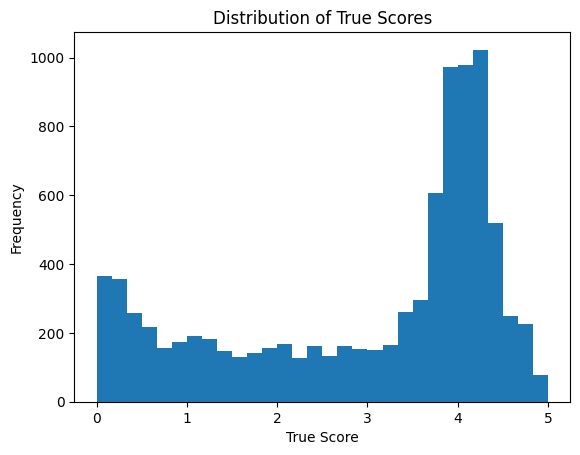

In [30]:
plt.hist(df[target], bins=30)
plt.xlabel("True Score")
plt.ylabel("Frequency")
plt.title("Distribution of True Scores")
plt.show()

In [ ]:
# 🔹 Apply log transformation to target
df[target] = np.log1p(df[target])  # log(1 + x) to handle zeros

# 🔹 Define X (features) and y (target)
X = df[features]
y = df[target]

# 🔹 Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 🔹 Apply PolynomialFeatures (degree = 2, allow squared terms)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [33]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

In [34]:
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=300,  # More boosting rounds
    learning_rate=0.05,  # Faster learning
    max_depth=6,  # Allow deeper trees
    num_leaves=20,  # More complex trees
    min_data_in_leaf=5,  # Prevent overfitting
    subsample=0.8,  # Use 80% of data for each tree
    colsample_bytree=0.8,  # Use 80% of features for each tree
    random_state=42
)

# 🔹 Train the model
lgbm.fit(X_train_scaled, y_train)


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6915
[LightGBM] [Info] Number of data points in the train set: 7128, number of used features: 35
[LightGBM] [Info] Start training from score 1.282028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, max_depth=6,
              min_data_in_leaf=5, n_estimators=300, num_leaves=20,
              objective='regression', random_state=42, subsample=0.8)

In [35]:
# 🔹 Save the trained model
model_filename = "lgbm_model.pkl"
joblib.dump(lgbm, model_filename)
print(f"Model saved as {model_filename}")

# 🔹 Save PolynomialFeatures transformer & Scaler
joblib.dump(poly, "poly_transform.pkl")
joblib.dump(scaler, "scaler.pkl")

Model saved as lgbm_model.pkl


['scaler.pkl']

In [38]:
y_pred = lgbm.predict(X_test_scaled)

# 🔹 Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 🔹 Display results
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Convert back using expm1
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"RMSE in Original Scale: {rmse_original}")


# 🔹 Check feature importance
importances = lgbm.feature_importances_
feature_names = poly.get_feature_names_out(features)
sorted_features = sorted(zip(importances, feature_names), reverse=True)

print("\nFeature Importance:")
for imp, name in sorted_features:
    print(f"{name}: {imp}")

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
Mean Squared Error: 0.24326879589061814
R-squared Score: 0.04838041504699575
RMSE in Original Scale: 1.4909541283241226

Feature Importance:
cost visibility: 317
pop_density traffic_rte: 311
visibility avg_price_level: 290
cost traffic_rte: 289
traffic_rte: 287
visibility Same_type_restaurants_no: 266
traffic_rte Total_no_restaurants: 253
cost pop_density: 249
traffic_rte visibility: 247
pop_density: 245
pop_density visibility: 225
visibility: 209
visibility Total_no_restaurants: 208
avg_price_level Total_no_restaurants: 207
pop_density Total_no_restaurants: 203
traffic_rte Same_type_restaurants_no: 197
cost Total_no_restaurants: 197
pop_density avg_price_level: 176
cost avg_price_level: 163
traffic_rte avg_price_level: 157
avg_price_level: 131
Total_no_restaurants: 117
avg_price_level Same_type_restaurants_no: 115
cost Same_type_restaurants_no: 99
Same_type_restauran

/home/rohanj48/code/majorp/backend/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [14]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler,StandardScaler
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 🔹 Load dataset
file_path = "combined77-true.xlsx"
df = pd.read_excel(file_path)

# 🔹 Select features and target
features = ["cost", "pop_density", "traffic_rte", "visibility", "avg_price_level", "Comp_Score"]
target = "true_score"

# 🔹 Convert target to numeric & drop missing values
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna()

# 🔹 Define X (features) and y (target)
X = df[features]
y = df[target]

# 🔹 Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Apply PolynomialFeatures (degree = 2, allow squared terms)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# 🔹 Scale features with MinMaxScaler (preserve feature relationships)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# 🔹 Define a more flexible LightGBM model
lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=300,  # More boosting rounds
    learning_rate=0.05,  # Faster learning
    max_depth=6,  # Allow deeper trees
    num_leaves=25,  # Increase model complexity
    min_data_in_leaf=3,  # Reduce constraints on leaf size
    subsample=0.8,  # Use 80% of data for each tree
    colsample_bytree=0.8,  # Use 80% of features per tree
    random_state=42
)

# 🔹 Train the model
lgbm.fit(X_train_scaled, y_train)

# 🔹 Save trained model
joblib.dump(lgbm, "lgbm_model.pkl")
joblib.dump(poly, "poly_transform.pkl")
joblib.dump(scaler, "scaler.pkl")

# 🔹 Make predictions
y_pred = lgbm.predict(X_test_scaled)

# 🔹 Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 🔹 Print results
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

# 🔹 Feature Importance Analysis
importances = lgbm.feature_importances_
feature_names = poly.get_feature_names_out(features)
sorted_features = sorted(zip(importances, feature_names), reverse=True)

print("\nFeature Importance Ranking:")
for imp, name in sorted_features:
    print(f"{name}: {imp}")


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5809
[LightGBM] [Info] Number of data points in the train set: 7128, number of used features: 27
[LightGBM] [Info] Start training from score 2.993330
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
Mean Squared Error: 2.072044311526553
Root Mean Squared Error: 1.4394597290395286
R-squared Score: 0.06884903721400892

Feature Importance Ranking:
visibility: 429
traffic_rte: 429
pop_density traffic_rte: 419
cost traffic_rte: 412
traffic_rte visibility: 406
cost visibility: 402
pop_density: 385
v

/home/rohanj48/code/majorp/backend/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [15]:
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")
    
from sklearn.metrics import mean_squared_error

# Convert back using expm1
y_pred_original = np.expm1(y_pred)
y_test_original = np.expm1(y_test)

rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
print(f"RMSE in Original Scale: {rmse_original}")

Actual: 4.9000, Predicted: 3.4559
Actual: 1.4011, Predicted: 3.1029
Actual: 2.3635, Predicted: 2.7315
Actual: 3.8000, Predicted: 3.3560
Actual: 3.3993, Predicted: 2.7292
Actual: 4.1000, Predicted: 3.2246
Actual: 0.0792, Predicted: 2.8752
Actual: 4.3000, Predicted: 3.4126
Actual: 3.6897, Predicted: 2.7221
Actual: 2.9530, Predicted: 2.9308
RMSE in Original Scale: 35.33984517956076


## removd poly has log on true score 
importtanat has rsquared of 0.07

In [45]:

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = "combined77-true.xlsx"
df = pd.read_excel(file_path)

# Select features (removed 'cost' due to low importance)
features = ["pop_density", "traffic_rte", "visibility", "avg_price_level", "Comp_Score"]
target = "true_score"

# Convert target to numeric & drop missing values
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna()

# Define X (features) and y (target)
X = df[features]
y = df[target]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define XGBoost model with optimized parameters
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    eval_metric="rmse",  # Specify evaluation metric
    early_stopping_rounds=50  # Early stopping to prevent overfitting
)

# Train the model
xgb.fit(
    X_train_scaled, y_train, 
    eval_set=[(X_test_scaled, y_test)], 
    verbose=False
)

# Save the trained model
joblib.dump(xgb, "xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved.")

# Make predictions
y_pred = xgb.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared Score:", r2)

# Display sample predictions
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")

Model and scaler saved.
Mean Squared Error: 2.06623063770985
Root Mean Squared Error: 1.437438916166475
R-squared Score: 0.0714616299764479
Actual: 4.9000, Predicted: 3.7895
Actual: 1.4011, Predicted: 2.8165
Actual: 2.3635, Predicted: 2.6592
Actual: 3.8000, Predicted: 3.3733
Actual: 3.3993, Predicted: 3.1400
Actual: 4.1000, Predicted: 3.4122
Actual: 0.0792, Predicted: 1.6588
Actual: 4.3000, Predicted: 2.9373
Actual: 3.6897, Predicted: 2.4753
Actual: 2.9530, Predicted: 2.9084


In [46]:
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")
print("Skewness of true_score:", y.skew())

Actual: 4.9000, Predicted: 3.7895
Actual: 1.4011, Predicted: 2.8165
Actual: 2.3635, Predicted: 2.6592
Actual: 3.8000, Predicted: 3.3733
Actual: 3.3993, Predicted: 3.1400
Actual: 4.1000, Predicted: 3.4122
Actual: 0.0792, Predicted: 1.6588
Actual: 4.3000, Predicted: 2.9373
Actual: 3.6897, Predicted: 2.4753
Actual: 2.9530, Predicted: 2.9084
Skewness of true_score: -0.744646226643782


In [73]:
## using optuna gives the highest r2 score YETT using xgboost
import pandas as pd
import numpy as np
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = "combined77-true.xlsx"
df = pd.read_excel(file_path)

# Select features (removed 'cost' due to low importance)
features = ["pop_density", "traffic_rte", "visibility", "avg_price_level", "Comp_Score"]
target = "true_score"

# Convert target to numeric & drop missing values
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna()

# Define X (features) and y (target)
X = df[features]
y = df[target]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features using StandardScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Optuna optimization function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0)
    }
    
    model = XGBRegressor(**params, random_state=42, eval_metric="rmse",early_stopping_rounds=50)
    model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
    
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Train final model with best parameters
best_params = study.best_params
xgb = XGBRegressor(**best_params, random_state=42, eval_metric="rmse", early_stopping_rounds=50)
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

# Save the trained model
joblib.dump(xgb, "xgb_model_optuna.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Optimized model and scaler saved.")

# Make predictions
y_pred = xgb.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print("Optimized Mean Squared Error:", mse)
print("Optimized Root Mean Squared Error:", rmse)
print("Optimized R-squared Score:", r2)

# Display sample predictions
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")

[I 2025-04-02 14:46:59,429] A new study created in memory with name: no-name-66ed6fa5-d172-48ce-9fd3-fd90e99e0f3c
[I 2025-04-02 14:46:59,536] Trial 0 finished with value: 2.120040449894451 and parameters: {'n_estimators': 550, 'learning_rate': 0.2650244285795488, 'max_depth': 7, 'colsample_bytree': 0.8679718124594156, 'subsample': 0.859724329398074, 'reg_alpha': 0.09419402890746364, 'reg_lambda': 0.5917954175532394}. Best is trial 0 with value: 2.120040449894451.
[I 2025-04-02 14:46:59,681] Trial 1 finished with value: 2.109267473321185 and parameters: {'n_estimators': 150, 'learning_rate': 0.012734908828826351, 'max_depth': 5, 'colsample_bytree': 0.6111499458640173, 'subsample': 0.9605192400272564, 'reg_alpha': 0.5800010284262261, 'reg_lambda': 0.6483396594354766}. Best is trial 1 with value: 2.109267473321185.
[I 2025-04-02 14:47:00,551] Trial 2 finished with value: 2.0376597714966396 and parameters: {'n_estimators': 650, 'learning_rate': 0.010576556057987498, 'max_depth': 7, 'colsam

Optimized model and scaler saved.
Optimized Mean Squared Error: 1.9944044221939004
Optimized Root Mean Squared Error: 1.4122338411870394
Optimized R-squared Score: 0.10373943859226675
Actual: 4.9000, Predicted: 3.9842
Actual: 1.4011, Predicted: 2.7124
Actual: 2.3635, Predicted: 2.6918
Actual: 3.8000, Predicted: 3.2158
Actual: 3.3993, Predicted: 3.1204
Actual: 4.1000, Predicted: 3.6127
Actual: 0.0792, Predicted: 1.3695
Actual: 4.3000, Predicted: 2.8940
Actual: 3.6897, Predicted: 2.6877
Actual: 2.9530, Predicted: 2.7498


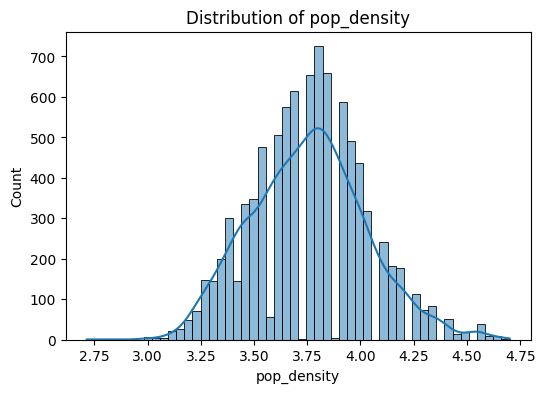

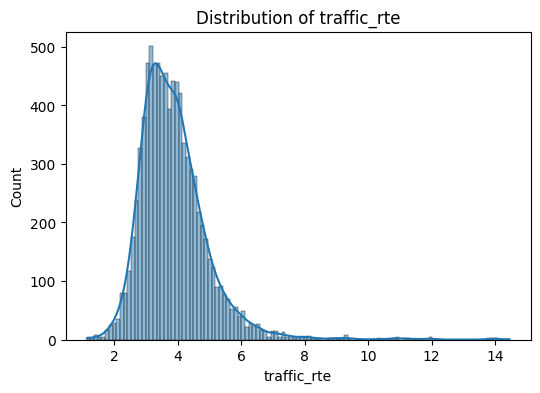

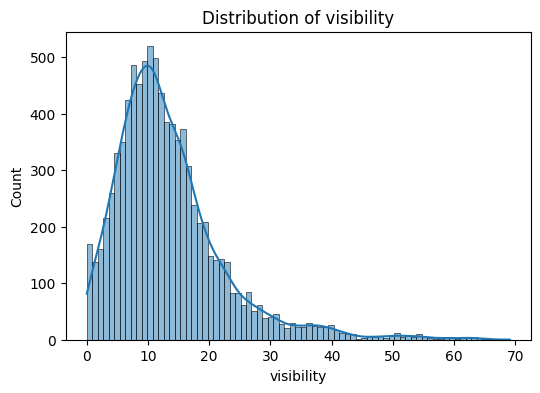

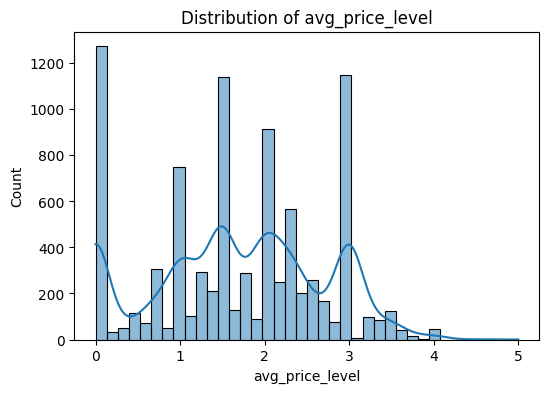

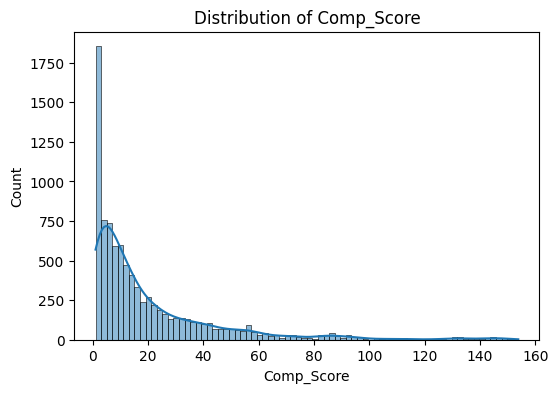

Skewness for pop_density: 0.21
Skewness for traffic_rte: 2.21
Skewness for visibility: 1.74
Skewness for avg_price_level: -0.10
Skewness for Comp_Score: 2.45


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()
from scipy.stats import skew

for col in features:
    skewness = skew(df[col].dropna())
    print(f"Skewness for {col}: {skewness:.2f}")

In [10]:
import pandas as pd
import numpy as np
import joblib
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = "combined77-true.xlsx"
df = pd.read_excel(file_path)

# Select features (removed 'cost' due to low importance)
features = ["pop_density", "traffic_rte", "visibility", "avg_price_level", "Comp_Score"]
target = "true_score"

# Convert target to numeric & drop missing values
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df.dropna()

# Apply log transformation to highly skewed features
skewed_features = ["traffic_rte", "visibility", "Comp_Score"]
for col in skewed_features:
    df[col] = np.log1p(df[col])  # log(1+x) transformation

# Define X (features) and y (target)
X = df[features]
y = df[target]

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define Optuna optimization function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0)
    }
    
    model = XGBRegressor(**params, random_state=42, eval_metric="rmse", early_stopping_rounds=50)
    model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)
    
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test, y_pred)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Train final model with best parameters
best_params = study.best_params
xgb = XGBRegressor(**best_params, random_state=42, eval_metric="rmse", early_stopping_rounds=50)
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

# Save the trained model
joblib.dump(xgb, "xgb_model_optuna.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Optimized model and scaler saved.")

# Make predictions
y_pred = xgb.predict(X_test_scaled)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print("Optimized Mean Squared Error:", mse)
print("Optimized Root Mean Squared Error:", rmse)
print("Optimized R-squared Score:", r2)

# Display sample predictions
for actual, predicted in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {actual:.4f}, Predicted: {predicted:.4f}")


[I 2025-04-02 15:36:20,231] A new study created in memory with name: no-name-036f70d4-ccc6-4950-8d67-051cf721d812
[I 2025-04-02 15:36:20,649] Trial 0 finished with value: 2.0940421215573317 and parameters: {'n_estimators': 350, 'learning_rate': 0.19280124060566722, 'max_depth': 9, 'colsample_bytree': 0.8242985869631098, 'subsample': 0.6327581801338733, 'reg_alpha': 0.0815904280471964, 'reg_lambda': 0.5804406974332816}. Best is trial 0 with value: 2.0940421215573317.
[I 2025-04-02 15:36:20,967] Trial 1 finished with value: 2.089915160829858 and parameters: {'n_estimators': 200, 'learning_rate': 0.21473392992048299, 'max_depth': 7, 'colsample_bytree': 0.9815195542097899, 'subsample': 0.6016389214940386, 'reg_alpha': 0.4090494926386572, 'reg_lambda': 0.4603204323418939}. Best is trial 1 with value: 2.089915160829858.
[I 2025-04-02 15:36:22,019] Trial 2 finished with value: 2.042398738353811 and parameters: {'n_estimators': 700, 'learning_rate': 0.032625823179920535, 'max_depth': 6, 'colsa

Optimized model and scaler saved.
Optimized Mean Squared Error: 1.9978778645449136
Optimized Root Mean Squared Error: 1.4134630750553456
Optimized R-squared Score: 0.10217851676673662
Actual: 4.9000, Predicted: 3.9258
Actual: 1.4011, Predicted: 2.8600
Actual: 2.3635, Predicted: 2.5387
Actual: 3.8000, Predicted: 3.2003
Actual: 3.3993, Predicted: 2.9870
Actual: 4.1000, Predicted: 3.7646
Actual: 0.0792, Predicted: 1.3341
Actual: 4.3000, Predicted: 2.7482
Actual: 3.6897, Predicted: 2.6524
Actual: 2.9530, Predicted: 2.5612


In [ ]:
## predictttt

import pandas as pd
import numpy as np
import joblib

# Load the trained model and scaler
xgb_model = joblib.load("xgb_model_optuna.pkl")
scaler = joblib.load("scaler.pkl")

# Define new data (replace with actual values)
new_data = pd.DataFrame({
    "pop_density": [5000],
    "traffic_rte": [3],
    "visibility": [7],
    "avg_price_level": [2],
    "Comp_Score": [0.8]
})

# Scale the new data using the loaded scaler
new_data_scaled = scaler.transform(new_data)

# Make predictions
predictions = xgb_model.predict(new_data_scaled)

# Display results
print("Predicted Success Score:", predictions[0])




